In [133]:
import pandas as pd
import numpy as np
import pycountry

## Load and prepare the data

Custom spreadsheet based on the [Activity classification](https://foundationaleconomy.com/activity-classification/) from the Foundational Economy Collective. In industry groups with different foundational types, we use the foundational type with the highest percentage, or if the shares are equal we pick the first "most important" in order of Material - Providential - Overlooked - Other.

In [134]:
foundational_percentages = pd.read_csv('../data/labor/foundational_percentages.csv')

Energy use data from IEA (World Indicators), Total Final Consumption per capita

In [135]:
energy_use_iea_csv = pd.read_csv('../data/biophysical/iea_indicators.csv')
energy_use_iea_tfcpop = energy_use_iea_csv[energy_use_iea_csv['FLOW'] == 'TFCPOP'].copy()

IEA energy use dataset only has ISO3 country codes, so convert to ISO2 using the `pycountry` library to match the other datasets.

In [136]:
def convert_iso3_to_iso2(iso3_code):
    country = pycountry.countries.get(alpha_3=iso3_code)
    return country.alpha_2 if country else None

energy_use_iea_tfcpop['geo'] = energy_use_iea_tfcpop['COUNTRY'].apply(convert_iso3_to_iso2)
energy_use_iea_tfcpop.rename(columns={'TIME': 'TIME_PERIOD', 'Value': 'energy'}, inplace=True)
energy_use_iea = energy_use_iea_tfcpop[['geo', 'energy', 'TIME_PERIOD']]
energy_use_iea = energy_use_iea[energy_use_iea['geo'].notna()]

Employment and hours worked data from the [EU labour costs survey](https://ec.europa.eu/eurostat/databrowser/view/lc_rnum1_r2/default/table?lang=en), collected every 4 years

In [137]:
labour_cost_survey_data = pd.read_csv('../data/labor/lc_nnum1_r2_linear.csv')

Employment and hours worked data from [National accounts](https://ec.europa.eu/eurostat/databrowser/view/nama_10_a64_e/default/table?lang=en), collected annually. Run the same regressions with this and the previous variable to see which one is best suited for the quantitative analysis.

In [138]:
labour_accounts_data = pd.read_csv('../data/labor/nama_10_a64_e_linear.csv')

Need satisfaction variables from World Development Indicators (School enrollment) and World Happiness Report (Life expectancy, Life satisfaction, etc.)

In [139]:
whr = pd.read_csv('../data/need_satisfaction/whr.csv')
school_enrollment = pd.read_csv('../data/need_satisfaction/wdi_schoolenr.csv')

In [140]:
def convert_name_to_iso2(country_name):
    if country_name == 'Türkiye' or country_name == 'Turkiye':
        return "TR"
    country = pycountry.countries.get(name=country_name)
    return country.alpha_2 if country else None
whr_with_codes = whr.copy()
whr_with_codes['geo'] = whr['Country name'].apply(convert_name_to_iso2)
whr_with_codes = whr_with_codes[whr_with_codes['geo'].notna()]
whr_with_codes.rename(columns={'year': 'TIME_PERIOD', 'Life Ladder': 'ladder', 'Social support': 'socialsupport', 'Healthy life expectancy at birth': 'hale', 'Freedom to make life choices': 'freedom', 'Generosity': 'charity', 'Perceptions of corruption': 'corruption', 'Positive affect': 'positive', 'Negative affect': 'negative'}, inplace=True)
whr_with_codes.drop(columns=['Country name', 'Log GDP per capita'], inplace=True)

In [141]:
from provisioning_model.functions.create_panel_dataset import clean_and_transform_wdi_outcomes
school_enrollment_cleaned = clean_and_transform_wdi_outcomes(school_enrollment, 'schoolenr')
school_enrollment_with_codes = school_enrollment_cleaned.copy()
school_enrollment_with_codes['geo'] = school_enrollment_with_codes['Country.Code'].apply(convert_iso3_to_iso2)
school_enrollment_with_codes = school_enrollment_with_codes[school_enrollment_with_codes['geo'].notna()]
school_enrollment_with_codes.rename(columns={'Year': 'TIME_PERIOD'}, inplace=True)
need_satisfaction = whr_with_codes.merge(school_enrollment_with_codes, on=['geo', 'TIME_PERIOD'], how='left')
need_satisfaction.drop(columns=['Country.Code', 'Country.Name'], inplace=True)

Count the number of unique countries that are available in both datasets.

In [142]:
labour_cost_survey_geo = labour_cost_survey_data.geo.unique()
energy_geo = energy_use_iea.geo.unique()
energy_lc_sv_shared_geo = np.intersect1d(labour_cost_survey_geo, energy_geo)
energy_lc_sv_shared_geo = np.delete(energy_lc_sv_shared_geo, np.where(energy_lc_sv_shared_geo == 'EU27_2020'))
print(f'The labour cost survey + energy intersection has {len(energy_lc_sv_shared_geo)} unique countries')
labour_accounts_geo = labour_accounts_data.geo.unique()
energy_lc_ac_shared_geo = np.intersect1d(labour_accounts_geo, energy_geo)
energy_lc_ac_shared_geo = np.delete(energy_lc_ac_shared_geo, np.where(energy_lc_ac_shared_geo == 'EU27_2020'))
print(f'The labour accounts + energy intersection has {len(energy_lc_ac_shared_geo)} unique countries')
print(
    f'Countries that are in the labour cost survey variant but not in labour accounts are: {np.setdiff1d(energy_lc_sv_shared_geo, energy_lc_ac_shared_geo)}')

The labour cost survey + energy intersection has 35 unique countries
The labour accounts + energy intersection has 32 unique countries
Countries that are in the labour cost survey variant but not in labour accounts are: ['AL' 'BA' 'TR']


Add the foundational type (`final_foundational` column) from `foundational_percentages` to the labour data.

In [143]:
foundational_percentages_selected = foundational_percentages[['nace_r2', 'final_foundational']]
labour_cost_survey_with_foundational = labour_cost_survey_data.merge(foundational_percentages_selected, on='nace_r2',
                                                                     how='left')
labour_accounts_with_foundational = labour_accounts_data.merge(foundational_percentages_selected, on='nace_r2',
                                                               how='left')

Only keep relevant columns. 

In [144]:
labour_cost_survey_filtered = labour_cost_survey_with_foundational[
    ['geo', 'nace_r2', 'final_foundational', 'sizeclas', 'worktime', 'indic_lc', 'TIME_PERIOD', 'OBS_VALUE']]
labour_accounts_filtered = labour_accounts_with_foundational[
    ['geo', 'nace_r2', 'final_foundational', 'na_item', 'TIME_PERIOD', 'OBS_VALUE']]

We are currently not interested in the size class of the enterprise in labour cost survey data (maybe in the future), so only keep `GE10` ("Greater than 10 employees"). 
There is a `TOTAL` size class, but the values for this are available for 33 countries as opposed 47 for `GE10`.

In [145]:
labour_cost_survey_filtered_sizeclas = labour_cost_survey_filtered[labour_cost_survey_filtered.sizeclas == 'GE10']
# unique_countries_per_sizeclas = labour_cost_survey_with_foundational.groupby('sizeclas')['geo'].nunique()

Only keep observations (country-years) for which both energy and labour data is available

In [146]:
labour_cost_survey_selected = labour_cost_survey_filtered_sizeclas[
    labour_cost_survey_filtered_sizeclas.geo.isin(energy_lc_sv_shared_geo)]
labour_accounts_selected = labour_accounts_filtered[labour_accounts_filtered.geo.isin(energy_lc_ac_shared_geo)]

Split the labour survey data into two datasets, one for employment and one for hours worked ("hours paid", not "hours actually worked" as there could be issues with how latter is reported (? confirm with RB and JV).
Filter out self-employed from the accounts data.

In [147]:
labour_cost_survey_selected_employment = labour_cost_survey_selected[
    labour_cost_survey_selected.indic_lc == 'SAL']
labour_cost_survey_selected_hours_worked = labour_cost_survey_selected[
    labour_cost_survey_selected.indic_lc == 'HP_SAL_Y']
labour_accounts_selected_employment = labour_accounts_selected[labour_accounts_selected.na_item == 'SAL_DC']

Only look at FTEs (full-time equivalents) in labour cost survey data, not to distinguish between full-time or part-time measures. This only applies to employment data, not hours worked.

In [148]:
labour_cost_survey_selected_employment_fte = labour_cost_survey_selected_employment[
    labour_cost_survey_selected_employment.worktime == 'TOT_FTE']

Calculate labour shares by foundational type for employment and hours.

In [149]:
import matplotlib.pyplot as plt
from provisioning_model.functions.create_panel_dataset import calculate_shares

In [150]:
labour_cost_survey_shares_employment_fte = calculate_shares(labour_cost_survey_selected_employment_fte, 'OBS_VALUE')
labour_cost_survey_shares_hours_worked = calculate_shares(labour_cost_survey_selected_hours_worked, 'OBS_VALUE')

Text(0.5, 1.0, 'Labor shares available per year')

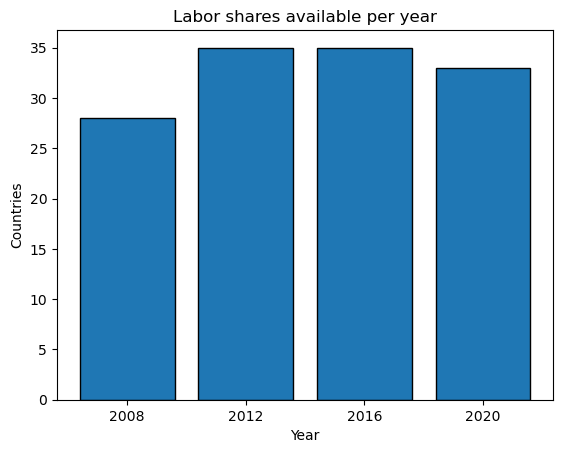

In [151]:
plt.hist(labour_cost_survey_shares_employment_fte['TIME_PERIOD'], bins=[y - 2 for y in [2008, 2012, 2016, 2020]] + [2022], edgecolor='black', align='mid', rwidth=0.8)
plt.xticks([2008, 2012, 2016, 2020]); plt.xlabel('Year'); plt.ylabel('Countries'); plt.title('Labor shares available per year')

In [152]:
energy_use_iea_selected_years = energy_use_iea[energy_use_iea['TIME_PERIOD'].isin([2008, 2012, 2016, 2020])]
energy_use_iea_selected = energy_use_iea_selected_years[energy_use_iea_selected_years.geo.isin(labour_cost_survey_shares_employment_fte.geo.unique())]

Text(0.5, 1.0, 'Energy use data available per year')

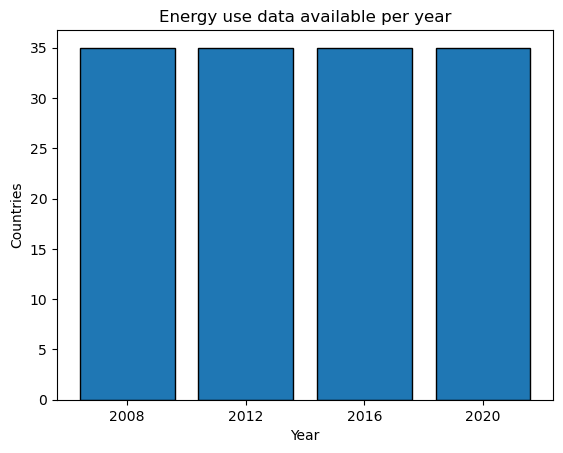

In [153]:
plt.hist(energy_use_iea_selected['TIME_PERIOD'], bins=[y - 2 for y in [2008, 2012, 2016, 2020]] + [2022], edgecolor='black', align='mid', rwidth=0.8)
plt.xticks([2008, 2012, 2016, 2020]); plt.xlabel('Year'); plt.ylabel('Countries'); plt.title('Energy use data available per year')

Assemble energy use, labor and need satisfaction data into a single dataset.

In [154]:
energy_use_employment = labour_cost_survey_shares_employment_fte.merge(energy_use_iea_selected, on=['geo', 'TIME_PERIOD'], how='left')
energy_use_employment_need_satisfaction = energy_use_employment.merge(need_satisfaction, on=['geo', 'TIME_PERIOD'], how='left')

In [155]:
foundational_df_no_transformations = energy_use_employment_need_satisfaction.rename(columns={'Material': 'material', 'Other': 'other', 'Overlooked': 'overlooked', 'Providential': 'providential'})

## Apply variable transformations

In [156]:
import numpy

1. Transform energy use variable to log

In [157]:
foundational_df_transformed = foundational_df_no_transformations.copy()
foundational_df_transformed["energy"] = foundational_df_no_transformations["energy"].apply(
    lambda x: numpy.log(x)
)

2. Transform need satisfaction variables using saturation transformation

In [162]:
need_satisfaction_variables = {
    # "lifesatisfaction": 10,
    "hale": 77,
    # "nutrition": 100.3,
    # "sanitation": 100.7,
    # "incomepoverty": 100.3,
    # "energyaccess": 100.7,
    "schoolenr": 102,
    # "socialsupport": 80,
}
for col in need_satisfaction_variables.keys():
    if col in foundational_df_no_transformations.columns:
        foundational_df_transformed[col] = foundational_df_no_transformations[col].apply(
            lambda x: numpy.log(need_satisfaction_variables[col] - x)
        )
        if foundational_df_transformed[col].isna().any():
            print(
                f"Warning: NaN values found in column {col}. Original values might be too close to or exceed the saturation point."
            )
    else:
        print(f"Warning: Column {col} not found in imputed DataFrame.")

/var/folders/6l/9wnlb_cx2h382r0y3jq99h5h0000gn/T/ipykernel_15698/1540903175.py:14: RuntimeWarning: invalid value encountered in log
  lambda x: numpy.log(need_satisfaction_variables[col] - x)


Transform provisioning factors using appropriate transformations.
Apply log transformation to foundational economy shares

In [160]:
provisioning_factor_variables = [
    "material",
    "other",
    "overlooked",
    "providential"
]
for col in provisioning_factor_variables:
    foundational_df_transformed[col] = foundational_df_no_transformations[col].apply(lambda x: numpy.log(x))

In [163]:
foundational_df_transformed

,geo,TIME_PERIOD,material,other,overlooked,providential,energy,ladder,socialsupport,hale,freedom,charity,corruption,positive,negative,schoolenr
0,AL,2012,-3.712974,-3.197966,-3.901023,-2.763731,-0.463624,5.510,0.785,2.179287,0.602,-0.170,0.848,0.553,0.271,0.832791
1,AL,2016,-4.488739,-4.186049,-3.679518,-3.444197,-0.366725,4.511,0.638,2.076312,0.730,-0.019,0.901,0.567,0.322,0.576626
2,AL,2020,-3.813518,-1.938164,-2.606284,-3.377976,-0.418550,5.365,0.710,2.063693,0.754,0.004,0.891,0.563,0.265,1.763450
3,AT,2008,-3.677127,-2.462311,-3.569925,-3.850713,1.176190,7.181,0.935,1.987874,0.879,0.287,0.614,0.716,0.173,0.628006
4,AT,2012,-3.663873,-2.448799,-3.552081,-3.991043,1.160334,7.401,0.945,1.931521,0.920,0.114,0.771,0.712,0.157,0.637250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,SK,2016,-3.774942,-2.704110,-4.239386,-3.308814,0.635518,5.993,0.945,2.216482,0.700,-0.063,0.917,0.688,0.232,2.355800
127,SK,2020,-3.799205,-2.716150,-4.292216,-3.256914,0.687632,6.519,0.954,2.113239,0.762,-0.079,0.901,0.695,0.274,2.414721
128,TR,2012,-3.488606,-2.626866,-3.248423,-4.040996,0.136278,5.309,0.739,2.280339,0.471,-0.219,0.702,0.506,0.335,2.832011
129,TR,2016,-3.888288,-2.705562,-3.406710,-4.180277,0.210261,5.326,0.880,2.211018,0.644,-0.068,0.764,0.414,0.390,NaN


## Key assumptions and parameters (TBD)

## Reproducing JV analysis with new data

## Exploratory analysis
General:

    How many unique countries, industries and regions in the resulting dataset? Any outliers?
    summary statistics (mean, median, mode, range, etc.) for key variables; how do these vary across countries

Energy Use Analysis:

    What is the distribution of energy use across the sampled countries?

Labor Share Analysis:

    How do labor shares vary across different foundational types?
    Which countries have the highest and lowest foundational shares in each sector?
    How does this change over time? Are there any trends in labor share changes over recent years?

Comparative Analysis:

    How do countries with similar economic profiles compare in terms of energy use, labor shares, and outcomes?
    Are there clusters of countries with similar characteristics?

Policy and Regulatory Impact:

    Are there noticeable impacts of policies or regulations on the observed data?

## Regression by sector (Later)
 - Use sectoral energy input (per cap? share?), sectoral labor share and sector-related need satisfaction variable

## Regression by region (Later)
 - Use total regional energy input (per cap? share?), total regional labor share and total regional need satisfaction variable

**Note**: We're not doing a fourth set of 
regressions by region + input due to data availability. Maybe in future research